# Implementation of a decoder only transformer structure

这个文档是对 ： https://waylandzhang.github.io/en/let-s-code-llm.html#step-4-transformer-block
的学习记录

这是一个transformer block的结构
![decoder only architecture](./image/image.png)

# Prepare the Environment 

In [150]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

# Setup Hyperparameters
超参数是模型的外部配置，在训练期间无法从数据中学习。它们是在训练过程开始之前设置的，在控制训练算法的行为和训练模型的性能方面起着至关重要的作用

In [151]:
batch_size = 4
context_length = 16 # Length of the token chunk each batch
d_model = 64 # Dimension of the model, also the dimension of the token embedding
num_layers = 8 # Number of transformer blocks
num_heads = 4 # Number of attention heads
learning_rate =1e-3 # 0.001
dropout = 0.1 # Dropout rate
max_iters = 5000 # Total of training iterations
eval_interval = 50 # How often to evaluate the model
eval_iters = 20 # Number of iterations to average for evaluation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

"""
在这段代码中，我们定义了一个名为 TORCH_SEED 的常量，并将其值设置为 1337。接下来，我们调用 torch.manual_seed(TORCH_SEED) 函数来设置 PyTorch 的随机数生成器的种子。

具体来说，torch.manual_seed 函数用于为所有设备（包括 CPU 和 GPU）设置随机数生成器的种子。这对于确保实验的可重复性非常重要，因为在机器学习和深度学习中，许多操作（如权重初始化、数据分割等）都依赖于随机数生成器。通过设置相同的种子，我们可以确保每次运行代码时，生成的随机数序列都是相同的，从而使实验结果具有可重复性。

在这个例子中，我们将种子设置为 1337，这意味着每次运行代码时，PyTorch 的随机数生成器都会使用这个种子来生成相同的随机数序列。这对于调试和比较不同模型的性能非常有用，因为它消除了由于随机性引入的变量。
"""
TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

# Prepare the Dataset

我们将使用一个小数据集进行训练。数据集是包含销售教科书的文本文档。
我们将使用文本文档来训练可以生成销售文本的语言模型

In [152]:
# download a sample txt file from huggingface
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print(len(text))
print(text[:1000])

460319
Chapter 1: Building Rapport and Capturing Attention
Subpoint: Understanding the Importance of Building Rapport
Building rapport is a fundamental skill in sales that cannot be underestimated. It lays the foundation for establishing a connection with your potential customers, gaining their trust, and ultimately convincing them to make a purchase. Rapport can be defined as a harmonious relationship based on mutual understanding and empathy. When you build rapport with someone, you create a sense of familiarity, comfort, and shared interests, making it easier to communicate and influence their decision-making process.
One of the main reasons why building rapport is crucial in sales is that people are more likely to buy from someone they like and trust. By establishing a positive and genuine connection with your customers, you increase their confidence in you and your product or service. People want to do business with individuals they feel comfortable with, those who understand thei

# Tokenization
我们将使用 TikToken 对数据集进行分词。

ref: [Tikoken introduction](https://juejin.cn/post/7390583568207822867)

In [153]:
encoding = tiktoken.get_encoding('cl100k_base') # 构造一个编码器
tokenized_text = encoding.encode(text) # 对文本进行编码,返回的是一个数字列表,数字代表token id

In [154]:
assert isinstance(tokenized_text, list) and isinstance(tokenized_text[0], int)

# 对列表里的token id去重,然后获取词汇表数量
vocab_size = len(set(tokenized_text))
max_token_value = max(tokenized_text)

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
Vocabulary size: 3771
The maximum value in the tokenized text is: 100069


# Word Embeding
我们将数据集分为训练集和验证集,训练集用于训练模型,验证集用于评估模型的性能。

In [155]:
# split train and validation
split_idx = int(len(tokenized_text) * 0.8)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

data = train_data
# 随机取一个batch_size大小的索引
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,)) 

# 根据索引取出实际的token, 得到的x_batch的维度是 (batch_size, context_length)
x_batch = torch.stack([torch.tensor(data[idx:idx + context_length]) for idx in idxs])
# y_batch[batch_idx][pos] 相当于 x_batch[batch_idx][pos+1]
y_batch = torch.stack([torch.tensor(data[idx + 1 : idx + 1 + context_length]) for idx in idxs])
print(x_batch)
print(y_batch)
print(x_batch.shape, y_batch.shape)

tensor([[  627,  1383, 88861,   279,  1989,   315, 25607, 16940, 65931,   323,
         32097,    11,   584, 26458, 13520,   449],
        [15749,   311,  9615,  3619,   872,  6444,     6,  3966,    11, 10742,
            11,   323, 32097,    13,  3296, 22815],
        [13189,   315,  1701,  5557,   304,  6763,   374, 88861,  7528, 10758,
          7526,    13,  4314,  7526,  2997,  2613],
        [  323,  6376,  2867, 26470,  1603, 16661,   264, 49148,   627,    18,
            13, 81745, 48023, 75311,  7246, 66044]])
tensor([[ 1383, 88861,   279,  1989,   315, 25607, 16940, 65931,   323, 32097,
            11,   584, 26458, 13520,   449,   264],
        [  311,  9615,  3619,   872,  6444,     6,  3966,    11, 10742,    11,
           323, 32097,    13,  3296, 22815, 14624],
        [  315,  1701,  5557,   304,  6763,   374, 88861,  7528, 10758,  7526,
            13,  4314,  7526,  2997,  2613,    11],
        [ 6376,  2867, 26470,  1603, 16661,   264, 49148,   627,    18,    13,
   

`y_batch` 的功能是在深度学习模型训练过程中，作为目标输出（标签）批次使用。这些子序列代表了模型在每个时间步或位置上应该预测的目标值。

在训练过程中，模型会使用输入批次（`x_batch`）来预测输出，然后将预测结果与 `y_batch` 中的目标值进行比较，以计算损失函数。通过最小化这个损失函数，模型可以逐渐学习到如何更准确地进行预测。因此，`y_batch` 在模型训练中起到了提供目标输出的关键作用。

# Positional Encoding

现在开始构造模型最开始的layer, 首先是创建一个embedding层, 它的作用是将token变成vector。（即构建一个从 token ID 到 token embedding 的映射）


![embeding layer](./image/embeding.png)

ref: [嵌入层 nn.Embedding() 详解和要点提醒（PyTorch）](https://github.com/Hoper-J/AI-Guide-and-Demos-zh_CN/blob/master/Guide/g.%20%E5%B5%8C%E5%85%A5%E5%B1%82%20nn.Embedding()%20%E8%AF%A6%E8%A7%A3%E5%92%8C%E8%A6%81%E7%82%B9%E6%8F%90%E9%86%92%EF%BC%88PyTorch%EF%BC%89.md)

In [156]:
# 这里用 max_token_value 而不是用 vocab_size 是因为
# 模型的映射范围要到 max_token_value 才能准确表达所有的 token。

# embedding_dim 设置成 d_model （超参数），可以理解为
# 通过这个layer，一个 token 会被表示为一个 (1, d_model) 的 vector
token_embedding_lookup_table = nn.Embedding(
        num_embeddings=max_token_value, 
        embedding_dim=d_model)

# Get X and Y embedding
x = token_embedding_lookup_table(x_batch)
y = token_embedding_lookup_table(y_batch)
print(x.shape, type(x)) 
# torch.Size([batch_size, context_length, d_model]) <class 'torch.Tensor'>

torch.Size([4, 16, 64]) <class 'torch.Tensor'>


接下来要给 embedded 后的 vector 加上 位置编码信息。

在一个batch里, 每个token都会有一个独特的位置编码信息，这个位置编码信息也是用一个维度为 (1, d_model) 的 vector 表示的。

假设某个token在输入序列中的位置是 pos，那在这个token对应的位置编码信息的vector中，

位于奇数位置的数值表示为
- `PE(POS, 2i+1) = cos(pos / 10000 ^ (2i/d_model))`

位于偶数位置的数值表示为
- `PE(pos, 2i) = sin(pos / 10000^ (2i/d_model))`


如果一个batch的输入序列的长度是 context_length , 那么它需要的位置编码对应的矩阵的 shape 是 ( context_length , d_model ), 接下来我们要构造这个矩阵

In [157]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)


# 求分母部分的数值
# make a list of odd numbers between range [ 0 , d_model ]
odds = torch.arange(0, d_model, 2) # tensor([ 0,  2,  4,  6,  8, 10, 12,..., 52, 54, 56, 58, 60, 62])
div_term = torch.exp(odds.float() * (-math.log(10000.0) / d_model))

# 构造一个表示位置的tensor
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1) # torch.Size([16, 1])
# 对每个token的embedded vector的偶数维度进行赋值计算
# [:, 0::2] 的含义是选择所有行，并且选择这些行中的偶数列（索引为 0, 2, 4, ... 的列）。
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
# 对每个token的embedded vector的奇数维度进行赋值计算
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)

# 为了方便处理输入，扩展维度
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch to the first dimension
print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape)

# Add position encoding to the token embedding
input_embedding_x = x + position_encoding_lookup_table
input_embedding_y = y + position_encoding_lookup_table


X = input_embedding_x

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


# Transformer Block

接下来要实现的是`transformer block`。

![transformer block.png](./image/transformerblock.png)




## Prepare Q,K,V
上面得到了带有位置信息编码的 token embedding vector 后。为了实现对上下文语义依赖的建模，进一步引入在自注意力机制中涉及到的三个元素：查询qi（Query），键ki（Key），值vi（Value）。


如图所示，输入序列中的每一个  token embedding vector （注意图中的 `Machine` 和 `Learning`两个单词下方的·`x1` , `x2`  ）通过三个线性变换 WQ，WK，WV ，得到其对应的qi ，ki，vi 向量.

![qkv](./image/qkv.png)

在这个图里面，x1 的维度 1 * 4 ， WQ 的维度 4 * 3 ，得到的 q1 向量是 1 * 3





我这里专门举一个特化的例子来直观感受 Q，K 矩阵相乘的现实逻辑。（合不合理另说）

假设输入 decoder 的输入序列是 "I am a human", 这句话被分成了 4 个 token，每个 token 又被转成 1 * 5 的 token embedding vector，
那么这个输入序列可以用一个 4 * 5 的矩阵 I 表示，


矩阵 I 通过 WQ， WK 得到图下两个矩阵Q和K。

Q 乘 K的转置 得到 一个 4  * 4 的矩阵， 这个矩阵的实际表示了token和token之间的“注意力关系”

比如 画红圈的地方，就表示了 单词 “am” 对 单词 “human” 的关注度。 

![qkv](./image/real.png)


值得注意的是，在训练的时候，单词 am 是看不到单词 human 的，因为 human 的位置 在 am 之后， human 应该是 am 在后面预测出来的单词。

所以在训练的时候会引用一个 mask 矩阵用来专门遮住那些 “不应该知道的注意力关系”，在这图中就是 右上角的部分。



In [158]:
# Prepare Query , Key, Value for Multi-head Attention

query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]

# Define Query, Key, Value weight matrices
# 这些矩阵里面的参数就是模型要训练的
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) # [4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model//num_heads) # [4, 16, 4, 16]
K = Wk(key) # [4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model//num_heads) # [4, 16, 4, 16]
V = Wv(value) # [4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model//num_heads) # [4, 16, 4, 16]

# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]


推荐阅读： 
- [[pytorch] Tensor shape 变化 view 与 reshape（contiguous 的理解）](https://www.bilibili.com/video/BV1Zw411y7Ks/?spm_id_from=333.1391.0.0)
- [[pytorch] Tensor 轴（axis）交换，transpose（转置）、swapaxes、permute](https://www.bilibili.com/video/BV1pN4y117rD/?spm_id_from=333.1391.0.0&vd_source=27d3b33a76014ebb5a906ad40fa382de)

这个地方比较难理解的地方是 “多头拆分” 的操作，因为从代码来看，所谓多头注意力不过也是把 d_model 拆成多个等分，参数量也没增加。


这个知乎回答解释这个问题 [为什么Transformer 需要进行 Multi-head Attention?](https://www.zhihu.com/question/341222779/answer/2466825259)

反正结论就是
> 如果h=1，那么最终可能得到的就是一个各个位置只集中于自身位置的注意力权重矩阵；如果h=2，那么就还可能得到另外一个注意力权重稍微分配合理的权重矩阵；h=3同理如此。因而多头这一做法也恰好是论文作者提出用于克服「模型在对当前位置的信息进行编码时，会过度的将注意力集中于自身的位置」的问题。

## Calculate QK^T Attention , Scale , Mask, Softmax, Matmul V

![image.png](./image/attention.png)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.271247,0.560849,-0.497451,-0.129847,-0.363947,-0.685937,0.185218,-0.109630,-0.582609,-0.399922,-0.526987,0.009846,0.095429,-0.417190,-0.294367,0.189911
1,-0.045627,0.335207,-0.261123,0.401420,-0.060369,0.060264,0.264576,0.356827,0.278763,-0.405287,0.052244,-0.403992,0.486559,0.041878,1.014870,0.202047
2,-0.062706,0.149768,-0.373623,-0.014540,0.501353,0.051065,0.528086,-0.215684,-0.363876,-0.507898,-0.526590,-1.015162,0.636725,-0.353699,0.629859,0.337414
3,0.489974,0.889258,-0.396356,0.726592,0.525897,-0.280680,-0.086415,-0.236879,-0.139481,0.180077,0.160038,-0.278772,0.029830,0.025996,0.100336,-0.437344
4,0.366094,0.809745,0.008297,0.004744,0.321938,-0.265212,-0.031628,0.000413,-0.327082,0.007050,0.058440,0.219607,0.311964,-0.035971,0.080204,0.044314
5,0.086670,0.772399,-0.768684,0.338177,0.517480,0.012420,0.335387,-0.283661,0.073089,-0.119132,-0.079181,0.178269,0.595736,0.069439,0.097363,0.496599
6,-0.917973,0.179699,-1.242398,0.295149,0.050819,-0.538681,0.316469,-0.602451,0.000879,0.257434,0.622034,-0.252260,0.048440,0.603582,-0.315566,-0.246330
7,0.485319,1.187169,-0.421335,0.609654,0.178571,-0.377602,-0.150101,-0.018908,0.147505,0.090906,0.280693,0.105192,0.616787,-0.289057,0.113308,0.034955
8,0.442679,1.010227,0.541597,0.759292,0.351397,0.068198,-0.331880,0.620946,0.515219,0.133559,0.251447,0.222155,-0.078039,0.416460,0.846286,0.007500
9,-0.378671,-0.184779,-0.172620,0.340819,0.176497,0.439594,0.154800,0.048620,0.835482,-0.098898,0.118051,0.307614,-0.602386,0.551086,0.633898,0.121890


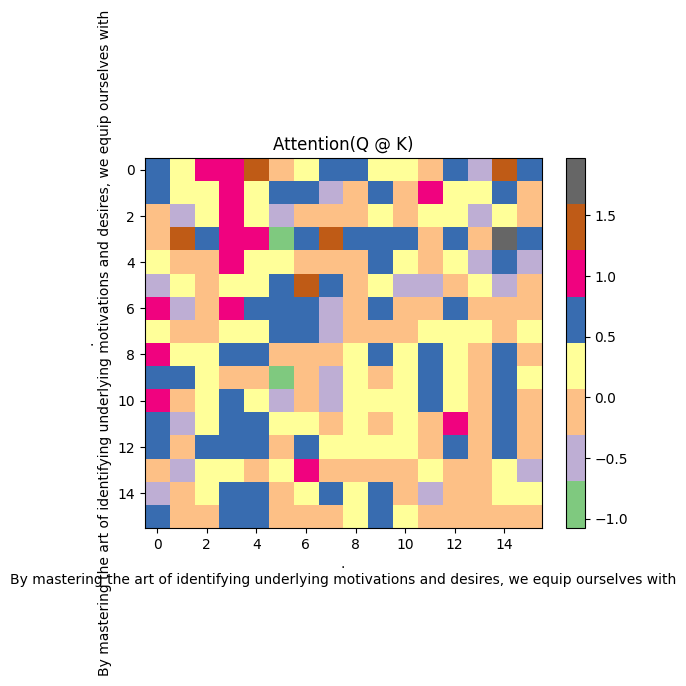

In [159]:
# Calculate the attention score betwee Q and K^T
# torch.matmul 对最后两维的矩阵做乘法
attention_score = torch.matmul(Q, K.transpose(-2, -1))

# Then Scale the attention score by the square root of the head size
attention_score = attention_score / math.sqrt(d_model // num_heads)


# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

接下来要考虑 mask，在 decoder only 的 transformer 模型中，被masked self-attention本质上起到序列填充的作用。

Decoder 只能查看以前的token，而不能查看未来的token。因此，多头注意力层的掩码要点是防止解码器“看到未来。

input: .
By mastering the art of identifying underlying motivations and desires, we equip ourselves with 
tokens [627, 1383, 88861, 279, 1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449] 
len: 16


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.271247,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.045627,0.335207,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.062706,0.149768,-0.373623,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.489974,0.889258,-0.396356,0.726592,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.366094,0.809745,0.008297,0.004744,0.321938,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,0.086670,0.772399,-0.768684,0.338177,0.517480,0.012420,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,-0.917973,0.179699,-1.242398,0.295149,0.050819,-0.538681,0.316469,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.485319,1.187169,-0.421335,0.609654,0.178571,-0.377602,-0.150101,-0.018908,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.442679,1.010227,0.541597,0.759292,0.351397,0.068198,-0.331880,0.620946,0.515219,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.378671,-0.184779,-0.172620,0.340819,0.176497,0.439594,0.154800,0.048620,0.835482,-0.098898,-inf,-inf,-inf,-inf,-inf,-inf


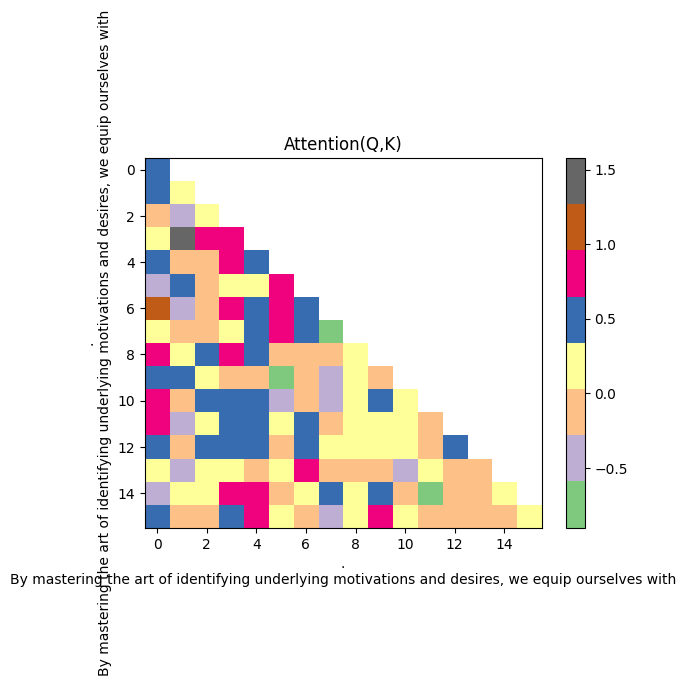

In [160]:
# construct mask shape
mask_shape=attention_score.shape[-2:] # [context_length, d_model//num_heads]
# make triangle shape
mask_bool = torch.triu(torch.ones(mask_shape), diagonal=1).bool()
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(mask_bool, float('-inf'))
# 这里设置成 负无穷 而不是 0 的原因是 方面后面 softmax 归一化的时候将这些无用的 -inf 变成 0


# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
xlable = encoding.decode(x_batch[0].tolist())
print("input:", xlable, "\ntokens", x_batch[0].tolist(), "\nlen:", len(x_batch[0].tolist()))
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

上面算出来的 attention_score 那个变量就是公式里 传入 softmax 的值

In [161]:
# softmax
attention_score = torch.softmax(attention_score, dim=-1)
# Calculate the V attention output
A = torch.matmul(attention_score, V) 

这里 dim 取 -1 可以理解为 softmax 对序列 attention_score[batch_idx][head_idx][token_idx][:] 进行归一化 , 也就是对每个 token 的 attention score 进行归一化。

ref：[pytorch | softmax(x,dim=-1)参数dim的理解](https://zhuanlan.zhihu.com/p/525276061)

## Concatenate and Output

接下来要做的是将多头注意力的结果reshape回原来的维度（对应图中的A），然后再传入一个线性网络.


![concatenate](./image/concate_and_output.png)

In [162]:
# [batch_size,  num_heads, context_length, head_size] -> [batch_size, context_length, head_num, head_size ]
A = A.transpose(1, 2) 
# [batch_size, context_length, head_num, head_size ] -> [batch_size, context_length, d_model]
A = A.reshape(batch_size, -1, d_model) 

现在开始构造线性层 Wo,这个线形层的输出就是所有多头注意力块的输出。

In [163]:
Wo = nn.Linear(d_model , d_model)
output = Wo(A)

print(output.shape)

torch.Size([4, 16, 64])


# Residual connecetion and FeedForward


完成了多头注意力的逻辑之后，要写图下红框处的结构。
![image.png](./image/rediual-connection-feed-forward.png)




In [164]:
# Add residual connection
output = output + X

# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)

# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4)(output)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)


# Add residual connection
output = output + X
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)




到目前为止，我们已经完成了一个transformer block。在实践中，我们将多个 transformer 块堆叠在一起，形成一个 transformer 解码器。


# Output Probabilities

![output probabilities](./image/output.png)


在推理过程中，你想从模型中获得下一个预测的token，但到目前为止我们得到的实际上是词汇表中所有标记的概率分布。

In [165]:
logits = nn.Linear(d_model, max_token_value)(output)
print(logits.shape) # [batch_size, context_length, vocab_size]
print(pd.DataFrame(logits[0].detach().cpu().numpy()))

torch.Size([4, 16, 100069])
      0         1         2         3         4         5         6       \
0  -0.198109 -0.024584 -0.390628 -0.509666 -0.651848 -0.803911  0.021912   
1   0.738735  0.621348 -0.293323  0.693907 -0.620036 -0.390120 -0.576853   
2   0.461873 -0.118239 -0.102895 -0.944984 -0.255343  0.026568  0.926112   
3  -0.594172  0.398664  0.292804 -0.800400 -0.337430 -0.212501  0.310157   
4  -0.627845  0.119776  0.000432 -0.299878  0.699299 -0.479650  0.159084   
5  -0.001701 -0.636552 -0.205869 -0.914698 -0.654249  0.303629  0.728939   
6  -0.556173 -0.015484  0.494321 -0.732023 -0.162457 -0.178356  0.327461   
7  -0.812433  0.003836 -0.903373 -0.397296 -0.450321  0.819017  0.168120   
8  -1.310561 -0.363689 -0.590449 -0.784727 -0.423371  0.130670 -0.028443   
9  -0.341814 -0.570835  0.131305 -0.092621  0.788680  0.772467  0.319421   
10  0.292164 -0.595430 -0.032514 -0.172319  0.704094  0.050517 -0.211032   
11  0.236014 -0.261912 -0.782080 -0.480625 -0.395048  0.3322

In [166]:
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)

print(probabilities)

tensor([[[6.9243e-06, 8.2364e-06, 5.7117e-06,  ..., 1.5728e-05,
          5.5565e-06, 4.8681e-06],
         [1.7647e-05, 1.5692e-05, 6.2871e-06,  ..., 2.0243e-05,
          4.2263e-06, 1.2627e-06],
         [1.3348e-05, 7.4728e-06, 7.5883e-06,  ..., 8.0100e-06,
          4.6040e-06, 1.4888e-05],
         ...,
         [3.7644e-06, 1.5663e-05, 9.6613e-06,  ..., 8.6265e-06,
          1.5848e-05, 6.4252e-06],
         [3.3098e-06, 7.8638e-06, 1.8554e-05,  ..., 4.7886e-06,
          1.3277e-05, 2.1676e-06],
         [5.0956e-06, 9.5217e-06, 7.6047e-06,  ..., 1.4421e-05,
          5.3195e-06, 5.4828e-06]],

        [[1.9918e-05, 5.9267e-06, 3.7477e-06,  ..., 8.6077e-06,
          3.9476e-06, 8.1714e-06],
         [4.3524e-06, 1.5325e-05, 6.8608e-06,  ..., 1.6760e-05,
          8.0599e-06, 6.1646e-06],
         [1.0009e-05, 6.1595e-06, 5.4430e-06,  ..., 1.4058e-05,
          8.3669e-06, 6.3447e-06],
         ...,
         [9.4713e-06, 1.3125e-05, 1.3630e-05,  ..., 8.1968e-06,
          1.291

在推理过程中我们实际上只需要取最后一个token对应的预测结果